# Notebook to plot exit wave of material from the C2DB
## (Smaller versions for later figures and supplementary online info)

Plots a figure showing a system, the three simulated images of it, the ground truth exit wave, the exit wave reconstructed by the neural network, and the difference.

The plots consist of 2 rows and 3 columns:
- The upper row showing structures and images, containing
  - The atomic structure
  - Two of the three images presented to the network
- The lower row showing exit waves (only imaginary parts), containing
  - The ground truth
  - The network prediction
  - The difference

(The plots are on identical scales)

## Run this to import the needed packages and functions

In [1]:
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from glob import glob
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
### import the desired neural network09080
from temnn.knet import Unet, MSDnet
###
from temnn.data.dataset import DataEntry,DataSet
from temnn.data.mods import local_normalize
from stm.feature.peaks import find_local_peaks, refine_peaks

from scipy.ndimage.filters import maximum_filter
from skimage.morphology import disk
from scipy.spatial import cKDTree as KDTree
import sys
import os
import json
from collections import deque
from multiprocessing import Pool
import ase.io
import skimage.io
from PIL import Image
import pandas as pd

num_gpus = 1
batch_size = 1 * num_gpus

/home/modules/software/Python/3.8.6-GCCcore-10.2.0/lib/python3.8/site-packages/cryptography/hazmat/bindings/openssl/binding.py:173: CryptographyDeprecationWarning: OpenSSL version 1.0.2 is no longer supported by the OpenSSL project, please upgrade. The next version of cryptography will drop support for it.
  warnings.warn(


# Choose the dataset you want to draw images from

In [2]:

data_dir = "../workflow/simulation_data/c2db_15pm-test/" 

# Path to the trained network
folder = '../workflow/trained_networks/c2db_15pm'



## Load neural network

In [3]:

model_path = os.path.join(folder, 'model-0')

# load the network
print('Loading model', model_path)
model = keras.models.load_model(model_path)
#model.summary(line_length=150)


Loading model ../workflow/trained_networks/c2db_15pm/model-0


## Load histogram data for image selection

We load the RMSD's of all the images so we can choose the median.

In [4]:
histdata = np.load(os.path.join(folder, 'histogram-epoch-model-0.npz'))
rmse = histdata['rel_rmse']
order = np.argsort(rmse)
median = len(order) // 2
print(median)
for i in (0, median, -2):
    j = order[i]
    print(i,j)
    print(rmse[j:j+1])

1060
0 1376
[0.12132472]
1060 1132
[0.31634764]
-2 1063
[2.29219961]


## Select and load image

To select images based on number:
* Set ``number`` to the number of the image, and ``percent`` to -1

To select images based on percentile:
* Do not set ``number`` but set ``percent`` to the relevant percentile.

In [5]:
# Choose a figure explicitly by setting percent to -1 and set number to the desired image.

percent = -1
#number = 1543   # PtSeCl inserts extra atoms (Fig. 8)
#number = 524    # AgCuTe2 fails to find broken symmetry (Fig. 7)

#  Choose a figure by percentage
percent = 95  # Five percent are worse

flip = False  # If the raytraced image should be mirrored in plane of view
if percent >= 0:
    nn = len(order)
    index = nn - percent * nn // 100
    print("{}%: Index {} of {}".format(percent, index, nn))
    number = order[index]
imagenumber = '000_{:04d}'.format(number)

# Load parameters
parameters = json.load(open(os.path.join(data_dir, 'parameters.json')))
imageparameters = json.load(open(os.path.join(data_dir, 'tem_params', 'parameters_'+imagenumber)))
image_size = parameters['image_size']
sampling = imageparameters['sampling']
normalizedistance = parameters['normalizedistance'] / sampling
defocus = imageparameters['defocus']

imagenumber = '000_{:04d}'.format(number)
print(number, imagenumber)
tmp = np.load(os.path.join(data_dir, 'images_labels', 'image_label_'+imagenumber+'.npz'))
image = tmp['image']
wave = tmp['label']

# Read the atoms
atoms = ase.io.read(os.path.join(data_dir, 'model', 'model_'+imagenumber.split('_')[1]+'.traj'))
formula = atoms.info['prototype']
print(formula)

# Load the image, if present
raytracedimagefile = 'MoS2_supported_raytrace_'+imagenumber.split('_')[1]
if not os.path.exists(raytracedimagefile+'.png'):
    print("Raytracing!")
    raytraced = None
    atoms.rotate(90, 'z')
    if flip:
        atoms.rotate(180, 'x')
    atoms.center(vacuum=1.0)
    ase.io.write(raytracedimagefile+'.pov', 
                 atoms, povray_settings=dict(celllinewidth=0.0, canvas_width=1000))
    os.system(f'module load POV-Ray; povray {raytracedimagefile}.ini')
raytraced = skimage.io.imread(raytracedimagefile+'.png')
# Cut the black border
raytraced = raytraced[5:-5,5:-5]
# Now crop the image, removing background except for a five pixels margin
bbox = Image.fromarray(raytraced).getbbox()
sh = raytraced.shape
bbox = (max(0, bbox[0]-1), max(0, bbox[1]-1), min(sh[1], bbox[2]+1), min(sh[0], bbox[3]+1))
raytraced = raytraced[bbox[1]:bbox[3],bbox[0]:bbox[2]]
# Some images are flipped - needs to be done manually
if flip:
    raytraced = raytraced[::-1,::-1]
else:
    raytraced = raytraced[:,::-1]

    
def rmse(a):
    return np.sqrt(np.mean(a*a))

print("Normalizing")
normimage = local_normalize(image.copy(), normalizedistance, normalizedistance)
print(wave.shape, wave.dtype, image.shape, image.dtype) 
print("Predicting")
predictions = model.predict(normimage)
print(predictions.shape, predictions.dtype)

diff = np.abs(wave - predictions)
print("RMSE:  Re = {}    Im = {}".format(rmse(diff[...,0]), rmse(diff[...,1])))
diff = abs(diff)
print("Worst difference:", diff.max())
print("   at position", np.unravel_index(diff.argmax(), diff.shape), "of", diff.shape)

# Scales for the plots
maxval = max(wave[0,:,:,:].max(), predictions[0,:,:,:].max())
minval = min(wave[0,:,:,:].min(), predictions[0,:,:,:].min())
print("Values in [{}, {}]".format(minval, maxval))
maxval = symval = max(-minval, maxval)
maxval = 1.08
minval = -maxval

# Find the worst position at least 20 pixels from the edge
edge = 20
#worstpos = np.unravel_index(np.abs(wave - predictions).argmax(), wave.shape)[1:3]
err = np.abs(wave - predictions)[0,edge:-edge,edge:-edge,:]
worstpos = np.unravel_index(err.argmax(), err.shape)[:2]
worstpos = np.array(worstpos) + edge
print("Worst postion", worstpos)
center = np.array(wave.shape[1:3]) // 2


95%: Index 106 of 2120
1794 000_1794
Br2Co
Normalizing
(1, 640, 640, 2) float32 (1, 640, 640, 3) float32
Predicting
(1, 640, 640, 2) float32
RMSE:  Re = 0.008874588645994663    Im = 0.011639896780252457
Worst difference: 0.21867168
   at position (0, 411, 431, 0) of (1, 640, 640, 2)
Values in [-0.3488215506076813, 1.0078459978103638]
Worst postion [411 431]


## Make the plots

<ipython-input-6-fe23adf4c73e>:60: FutureWarning: skimage.util.pad is deprecated and will be removed in version 0.19. Please use numpy.pad instead.
  raytraced_pad = skimage.util.pad(raytraced, ((dx1, dx2), (0, 0), (0,0)))


Filename: fig_c2db_1794_Br2Co_RMSE0_0104_95percent


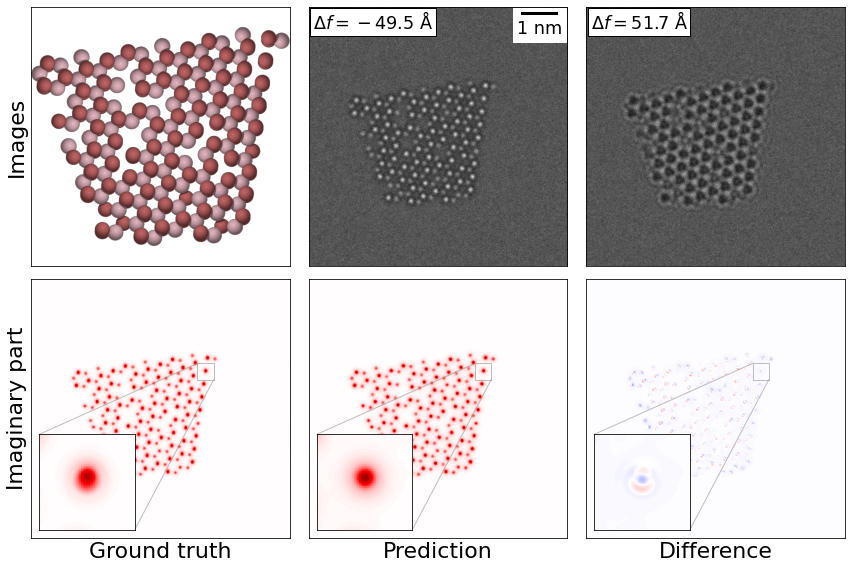

In [6]:
# Actual plotting
cmap = 'seismic'
zoom = True
textsize = 22
if zoom:
    def myplot(ax, data, **kwargs):
        ax.imshow(data, origin='lower', **kwargs)
        ax.set_xticks([])
        ax.set_yticks([])
        # Make insert, depending on where the maximum is
        d = 0.03
        s = 0.4
        x = worstpos - center
        #print(worstpos, center, x)
        if x[0] < 0 and x[1] < 0:
            pos = [1 - s, 1 - s]
        elif x[0] >= 0 and x[1] < 0:
            pos = [1 - s, d]
        elif x[0] < 0 and x[1] >= 0:
            pos = [d, 1 - s]
        else:
            pos = [d, d]
        ins = ax.inset_axes(pos + [s - d, s - d])
        ins.imshow(data, origin='lower', **kwargs)
        ins.set_xlim(worstpos[1] - 20, worstpos[1] + 20)
        ins.set_ylim(worstpos[0] - 20, worstpos[0] + 20)
        ins.set_xticks([])
        ins.set_yticks([])
        ax.indicate_inset_zoom(ins)
else:
    def myplot(ax, data, **kwargs):
        ax.imshow(data, **kwargs)
        ax.set_xticks([])
        ax.set_yticks([])
        
# Actual plotting
fig, ax = plt.subplots(2,3,figsize=(12,8))

overlay = False  # Do not put structure on top of image
if overlay:
    for i in range(3):
        if i != 2 or raytraced is None:
            ax[0][i].imshow(image[0,:,:,i], origin='lower', cmap='gray')
        ax[0][i].set_xticks([])
        ax[0][i].set_yticks([])

    if raytraced is not None:
        ax[0][2].imshow(mergeimages(image[0,:,:,i], raytraced, 0.7),
                        origin='lower')  
else:
    if raytraced is not None:
        xsize, ysize, _ = raytraced.shape
        if xsize > ysize:
            dy1 = (xsize - ysize) // 2
            dy2 = xsize - ysize - dy1
            raytraced_pad = skimage.util.pad(raytraced, ((0, 0), (dy1, dy2), (0,0)))
        elif ysize > xsize:
            dx1 = (ysize - xsize) // 2
            dx2 = ysize - xsize - dx1
            raytraced_pad = skimage.util.pad(raytraced, ((dx1, dx2), (0, 0), (0,0)))
        xsize, ysize, _ = raytraced_pad.shape
        assert xsize == ysize
        ax[0][0].imshow(raytraced_pad)
        # Find common minimal and maximal values for the three images
        imgmin = min([image[0,:,:,i].min() for i in range(3)])
        imgmax = max([image[0,:,:,i].max() for i in range(3)])
        ax[0][1].imshow(image[0,:,:,0], origin='lower', cmap='gray',
                        vmin=imgmin, vmax=imgmax) # Note img 0 !!
        ax[0][2].imshow(image[0,:,:,2], origin='lower', cmap='gray',
                        vmin=imgmin, vmax=imgmax)
        ax[0][1].text(10, image_size[1] - 10, 
                  f'$\Delta f = {defocus[0]:.1f}$ Å',
                  ha='left', va='top',
                  bbox=dict(fc='white', ec=None, boxstyle='square,pad=0.15'),
                  fontsize = 0.8 * textsize)
        ax[0][2].text(10, image_size[1] - 10, 
                  f'$\Delta f = {defocus[2]:.1f}$ Å',
                  ha='left', va='top',
                  bbox=dict(fc='white', ec=None, boxstyle='square,pad=0.15'),
                  fontsize = 0.8 * textsize)
    else:
        for i in range(3):
            ax[0][i].imshow(image[0,:,:,i], origin='lower', cmap='gray')
    for i in range(3):
        ax[0][i].set_xticks([])
        ax[0][i].set_yticks([])

ax[0][0].set_ylabel('Images', fontsize=textsize)

myplot(ax[1][0], wave[0,:,:,1], 
       cmap=cmap, vmax = maxval, vmin = minval)
myplot(ax[1][1], predictions[0,:,:,1], 
       cmap=cmap, vmax = maxval, vmin = minval)
myplot(ax[1][2], wave[0,:,:,1]-predictions[0,:,:,1], 
       cmap=cmap, vmax = symval, vmin = -symval)
#ax[1][0].set_ylabel('Real part', fontsize=20)
ax[1][0].set_ylabel('Imaginary part', fontsize=textsize)
ax[1][0].set_xlabel('Ground truth', fontsize=textsize)
ax[1][1].set_xlabel('Prediction', fontsize=textsize)
ax[1][2].set_xlabel('Difference', fontsize=textsize)
# Place a scalebar
scalebar = ScaleBar(0.1*sampling, 'nm', fixed_value=1, pad=0.4, font_properties={'size': 0.8 * textsize})
ax[0][int(not overlay)].add_artist(scalebar)

rmse = np.sqrt(np.mean((predictions - wave)**2))
filename = f"fig_c2db_{number:04d}_{formula}_RMSE{rmse:.4f}"
if percent > 0:
    filename = filename + '_{}percent'.format(percent)
filename = filename.replace('.', '_')
print("Filename:", filename)
plt.tight_layout()
plt.savefig(filename+'.png', dpi=300)
None  

Print the RMSE for the figure label

In [7]:
rmse_re = np.sqrt(np.mean((predictions - wave)[...,0]**2))
rmse_im = np.sqrt(np.mean((predictions - wave)[...,1]**2))
rmse = np.sqrt(np.mean((predictions - wave)**2))

print("RMSE:", rmse_re, rmse_im, rmse)

RMSE: 0.008874589 0.011639897 0.010350012


## Find peaks for figure text.

Print how much the peaks are misplaced in pixels or Ångström.

In [8]:
peaks = find_local_peaks(predictions[0,:,:,1], min_distance=10, 
                         threshold=0.70, exclude_border=10,
                         exclude_adjacent=True).astype(int)
peaks = refine_peaks(predictions[0,:,:,1], peaks, 7, 'polynomial')
wavepeaks = find_local_peaks(wave[0,:,:,1], min_distance=10, 
                         threshold=0.70, exclude_border=10,
                         exclude_adjacent=True).astype(int)
wavepeaks = refine_peaks(wave[0,:,:,1], wavepeaks, 7, 'polynomial')

print(len(peaks), len(wavepeaks))

73 73


In [9]:
#assert len(peaks) <= len(wavepeaks)
kdt = KDTree(wavepeaks)
hits = kdt.query_ball_point(peaks, 5)
displacements = []
for i, h in enumerate(hits):
    xy = peaks[i]
    if len(h) == 0:
        continue
    hitxy = wavepeaks[h[0]]
    displacements.append(xy - hitxy)
displacements = np.array(displacements)

In [10]:
np.linalg.norm(displacements, axis=1).max()

0.8148299861805706

In [11]:
np.linalg.norm(displacements, axis=1).max() * sampling

0.08936755373945943